# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from catboost import CatBoostClassifier
import shap

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 데이터 읽어오기


In [2]:
ROOT_DIR = "data"
random_seed = 110

# Load data
train_data = pd.read_csv("train.csv")
train_data
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data = test_data[train_data.columns]

In [3]:
train_data['Chamber Temp. Judge Value_AutoClave'] = (train_data['Chamber Temp. Judge Value_AutoClave']=="OK").replace({True: 1, False: 0})
test_data['Chamber Temp. Judge Value_AutoClave'] = (test_data['Chamber Temp. Judge Value_AutoClave'] == "OK").replace({True: 1, False: 0})

In [4]:
# 원-핫 인코딩을 적용할 컬럼 리스트
cat_cols = ['Equipment_Dam','Equipment_Fill1','Equipment_Fill2','Model.Suffix_Dam', 'Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2']
train_data[cat_cols]

,Equipment_Dam,Equipment_Fill1,Equipment_Fill2,Model.Suffix_Dam,Model.Suffix_AutoClave,Model.Suffix_Fill1,Model.Suffix_Fill2
0,Dam dispenser #1,Fill1 dispenser #1,Fill2 dispenser #1,AJX75334505,AJX75334505,AJX75334505,AJX75334505
1,Dam dispenser #1,Fill1 dispenser #1,Fill2 dispenser #1,AJX75334505,AJX75334505,AJX75334505,AJX75334505
2,Dam dispenser #2,Fill1 dispenser #2,Fill2 dispenser #2,AJX75334501,AJX75334501,AJX75334501,AJX75334501
3,Dam dispenser #2,Fill1 dispenser #2,Fill2 dispenser #2,AJX75334501,AJX75334501,AJX75334501,AJX75334501
4,Dam dispenser #1,Fill1 dispenser #1,Fill2 dispenser #1,AJX75334501,AJX75334501,AJX75334501,AJX75334501
...,...,...,...,...,...,...,...
40501,Dam dispenser #1,Fill1 dispenser #1,Fill2 dispenser #1,AJX75334501,AJX75334501,AJX75334501,AJX75334501
40502,Dam dispenser #2,Fill1 dispenser #2,Fill2 dispenser #2,AJX75334501,AJX75334501,AJX75334501,AJX75334501
40503,Dam dispenser #1,Fill1 dispenser #1,Fill2 dispenser #1,AJX75334501,AJX75334501,AJX75334501,AJX75334501
40504,Dam dispenser #2,Fill1 dispenser #2,Fill2 dispenser #2,AJX75334501,AJX75334501,AJX75334501,AJX75334501


In [5]:
model_cols = [
    'Model.Suffix_Dam',
    'Model.Suffix_AutoClave',
    'Model.Suffix_Fill1',
    'Model.Suffix_Fill2'
]

train_data['Model'] = train_data[model_cols[0]]
test_data['Model'] = test_data[model_cols[0]]

train_data = train_data.drop(model_cols, axis=1)
test_data = test_data.drop(model_cols, axis=1)

In [6]:
judge_cols = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
]

train_data['Judge'] = (train_data[judge_cols[0]]=='OK').replace({True: 1, False: 0})
test_data['Judge'] = (test_data[judge_cols[0]]=='OK').replace({True: 1, False: 0})

train_data = train_data.drop(judge_cols, axis=1)
test_data = test_data.drop(judge_cols, axis=1)

In [7]:
workorder_cols = [
    'Workorder_Dam',
    'Workorder_AutoClave',
    'Workorder_Fill1',
    'Workorder_Fill2',
]

train_data['Workorder'] = train_data[workorder_cols[0]]
test_data['Workorder'] = test_data[workorder_cols[0]]

train_data = train_data.drop(workorder_cols, axis=1)
test_data = test_data.drop(workorder_cols, axis=1)

In [8]:
target_cols = [
    'Equipment_Dam',
    'Equipment_Fill1',
    'Equipment_Fill2',
]

train_data['Equipment'] = train_data['Equipment_Dam'] + '_' + train_data['Equipment_Fill1'] + '_' + train_data['Equipment_Fill2']
test_data['Equipment'] = test_data['Equipment_Dam'] + '_' + test_data['Equipment_Fill1'] + '_' + test_data['Equipment_Fill2']
train_data = train_data.drop(target_cols, axis=1)
test_data = test_data.drop(target_cols, axis=1)

In [9]:
drop_cols = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
]

train_data = train_data.drop(drop_cols, axis=1)
test_data = test_data.drop(drop_cols, axis=1)

In [10]:
# DataFrame에서 object 타입의 컬럼만 뽑아내기
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()

# 추출된 컬럼들 출력
train_data[object_columns]

,target,Model,Workorder,Equipment
0,Normal,AJX75334505,4F1XA938-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
1,Normal,AJX75334505,3KPM0016-2,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
2,Normal,AJX75334501,4E1X9167-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
3,Normal,AJX75334501,3K1X0057-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
4,Normal,AJX75334501,3HPM0007-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
...,...,...,...,...
40501,Normal,AJX75334501,3J1XF434-2,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
40502,Normal,AJX75334501,4E1XC796-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
40503,Normal,AJX75334501,4C1XD438-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
40504,Normal,AJX75334501,3I1XA258-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...


In [11]:
train_data['target'] = train_data['target'].map({'AbNormal':1, 'Normal':0})

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 136 entries, CURE END POSITION X Collect Result_Dam to Equipment
dtypes: float64(68), int64(65), object(3)
memory usage: 42.0+ MB


In [13]:
# 기본 설정
n_splits = 5

# Stratified KFold 설정
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

In [14]:
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
X_test = test_data[X_train.columns]

In [15]:
object_columns = X_train.select_dtypes(include=['object']).columns.tolist()

In [16]:
scores = []
models = []

for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = CatBoostClassifier(random_state=101, 
                               eval_metric="F1", 
                               cat_features=object_columns,
                               iterations=4000)
    model.fit(X_tr, y_tr,
             eval_set=[(X_val, y_val)],
#              early_stopping_rounds=100,
             verbose=500)
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])

Learning rate set to 0.040938
0:	learn: 0.0010633	test: 0.0000000	best: 0.0000000 (0)	total: 85.8ms	remaining: 5m 42s
500:	learn: 0.1384083	test: 0.0965795	best: 0.0965795 (405)	total: 11.9s	remaining: 1m 23s
1000:	learn: 0.1973180	test: 0.1192843	best: 0.1230159 (802)	total: 23.2s	remaining: 1m 9s
1500:	learn: 0.2525534	test: 0.1333333	best: 0.1333333 (1471)	total: 34.5s	remaining: 57.4s
2000:	learn: 0.2921960	test: 0.1481481	best: 0.1481481 (1963)	total: 45.8s	remaining: 45.8s
2500:	learn: 0.3291925	test: 0.1475728	best: 0.1514563 (2164)	total: 57.3s	remaining: 34.3s
3000:	learn: 0.3725151	test: 0.1544402	best: 0.1579961 (2979)	total: 1m 10s	remaining: 23.4s
3500:	learn: 0.4204784	test: 0.1538462	best: 0.1579961 (2979)	total: 1m 31s	remaining: 13s
3999:	learn: 0.4611611	test: 0.1538462	best: 0.1579961 (2979)	total: 1m 53s	remaining: 0us

bestTest = 0.1579961464
bestIteration = 2979

Shrink model to first 2980 iterations.
Learning rate set to 0.040939
0:	learn: 0.0178853	test: 0.01265

In [17]:
print(scores)
print(np.mean(scores))

[0.1579961464354528, 0.13307240704500978, 0.11023622047244096, 0.1634980988593156, 0.15057915057915058]
0.14307640467827396


In [18]:
# Threshold 값을 테스트할 범위 설정
thresholds = np.arange(0.0, 0.3, 0.01)  # 0.1에서 0.9까지 0.05 간격으로 테스트
best_threshold = 0
best_score = 0
best_scores = []

# 각 threshold에 대해 f1_score 계산
for threshold in thresholds:
    pred_list = []
    scores = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        # 예측 확률 계산
        pred = models[fold].predict_proba(X_train.iloc[valid_index])
        
        # Threshold 적용하여 클래스 결정
        pred = np.where(pred[:,1] >= threshold, 1, 0)
        
        # f1_score 계산
        score = f1_score(y_train[valid_index], pred)
        scores.append(score)

    # 현재 threshold에 대한 평균 f1_score 계산
    mean_score = np.mean(scores)
    print(f"Threshold: {threshold}, F1 Score: {mean_score}")

    # 최적의 threshold 업데이트
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = threshold
        best_scores = scores

# 최적의 threshold 및 해당 f1_score 출력
print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_score}")
print(f"Scores for Best Threshold: {best_scores}")


Threshold: 0.0, F1 Score: 0.1096695914279304
Threshold: 0.01, F1 Score: 0.11109856232651008
Threshold: 0.02, F1 Score: 0.11969509505888598
Threshold: 0.03, F1 Score: 0.13435601717342313
Threshold: 0.04, F1 Score: 0.15016494696096389
Threshold: 0.05, F1 Score: 0.1664139693246743
Threshold: 0.06, F1 Score: 0.1796424784579141
Threshold: 0.07, F1 Score: 0.1894044850287173
Threshold: 0.08, F1 Score: 0.19871512370487615
Threshold: 0.09, F1 Score: 0.2092656076623849
Threshold: 0.1, F1 Score: 0.21653939328478516
Threshold: 0.11, F1 Score: 0.22095662714659645
Threshold: 0.12, F1 Score: 0.22257409071591874
Threshold: 0.13, F1 Score: 0.2237376086221327
Threshold: 0.14, F1 Score: 0.22080278636999484
Threshold: 0.15, F1 Score: 0.21752447262137048
Threshold: 0.16, F1 Score: 0.21469647468422495
Threshold: 0.17, F1 Score: 0.20800427800757024
Threshold: 0.18, F1 Score: 0.2032575886591032
Threshold: 0.19, F1 Score: 0.20070592699786607
Threshold: 0.2, F1 Score: 0.19808359059830682
Threshold: 0.21, F1 Sco

In [19]:
# 최적의 threshold를 사용해 X_test 예측
final_predictions = []

for fold in range(len(models)):
    # X_test에 대한 예측 확률 계산
    pred = models[fold].predict_proba(X_test)
    
    # 최적의 threshold 적용하여 클래스 결정 (0 또는 1)
    pred = np.where(pred[:,1] >= best_threshold, 1, 0)
    
    # 예측 결과 저장
    final_predictions.append(pred)

# 모든 폴드의 예측 결과를 합쳐서 최종 결론 도출
# 각 폴드에서의 예측 결과를 평균내고, 이를 기준으로 최종 결론 도출
final_predictions = np.mean(final_predictions, axis=0)
final_predictions = np.where(final_predictions >= best_threshold, 1, 0)

# 최종 예측 결과 출력
print("Final Predictions for X_test:")
print(final_predictions)

Final Predictions for X_test:
[0 0 0 ... 0 0 0]


In [20]:
# 매핑 함수 정의
mapping = {1: 'AbNormal', 0: 'Normal'}
map_func = np.vectorize(mapping.get)

# 배열에 매핑 함수 적용
arr_mapped = map_func(final_predictions)

In [21]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = arr_mapped

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [22]:
models[0].get_feature_importance(prettified=True).to_csv("importance.csv", index=False)

In [23]:
models[0].get_feature_importance(prettified=True)

,Feature Id,Importances
0,Workorder,10.856466
1,1st Pressure Collect Result_AutoClave,5.667569
2,Chamber Temp. Collect Result_AutoClave,5.381149
3,PalletID Collect Result_Fill2,5.192363
4,2nd Pressure Collect Result_AutoClave,4.584629
...,...,...
130,Head Clean Position Y Collect Result_Fill1,0.000000
131,Head Clean Position Z Collect Result_Fill1,0.000000
132,CURE END POSITION X Collect Result_Fill2,0.000000
133,Head Clean Position Z Collect Result_Fill2,0.000000


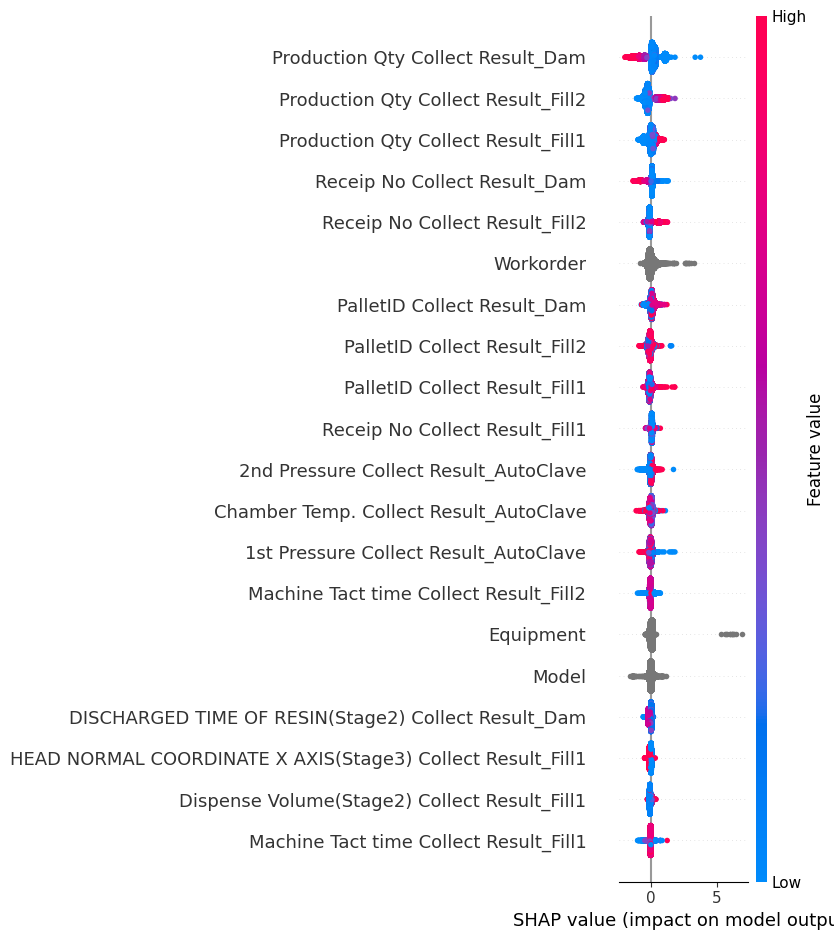

In [24]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X_test)

# SHAP 피처 중요도 시각화
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)